A Simple Fjord Ecosystem Model
==============================

Following Franks, et al. (1986, Marine Biology, v91, 121–129), we wish to build a nitrate (N), phytoplankton (P), and Zooplankton (Z) model (NPZ) that also adds some basic benthic cycling: i) dead, sinking phytoplankton does not primarily remineralize in the water column and is exported to the benthos; and, ii) nutrients are exported from the Benthos. The system of equations for the system are given by:

\begin{equation}
\begin{split}
\frac{dN}{dt} & = -\frac{V_m N}{k_s+N}P+mP+gZ+\gamma R_m\Lambda P(1-e^{-\Lambda P})Z+\beta B \hspace{2in}(1)\\
\frac{dP}{dt} & = \frac{V_m N}{k_s+N}P-mP-R_m\Lambda P(1-e^{-\Lambda P})Z-\alpha P \hspace{2.75in}(2)\\
\frac{dZ}{dt} & = (1-\gamma)R_m\Lambda P(1-e^{-\Lambda P})Z - gZ \hspace{3.5in}(3) \\
\frac{dB}{dt} & = \alpha P - \beta B \hspace{5in}(4)
\end{split}
\end{equation}

The parameters are given in the table below, and for the first portion of these experiments, we will use the Ivlev formulation ($\alpha=1$). Note that these equations solve for concentrations; hence, N, P, Z, and B are in units of $\mu$gN L$^{-1}$.



| Parameter | Description                                    | Value        |
|-----------|------------------------------------------------|--------------|
|  $V_m$    | Maximum $P$ growth rate                        | 2 day$^{-1}$ |
|  $k_s$    | Half-Saturation constant for $N$               | 1 $\mu$gN L$^{-1}$ |
|  $m$      | $P$ mortality rate remineralized in water water| 0.1 day$^{-1}$ |
|  $\alpha$ | $P$ mortality rate remineralized in benthos    | 0.025 day$^{-1}$ |
|  $\beta$  | resuspension rate of $N$ from the benthos      | 0.01 day$^{-1}$ |
|  $\gamma$ | Unassimilated grazing fraction from ("messy eating" percentage) | 0.3 |
|  $R_m$    | Maximum $Z$ grazing rate                       | 1.5 day$^{-1}$ |
|  $\Lambda$| Ivlev constant                                 | 1 L $(\mu$gN$)^{-1}$ |
|  $g$      | $Z$ mortality rate                             | 0.2 day$^{-1}$ |



Modules
------

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc

##  Parameters

1. tstart: time to start model integration [days]
1. tend: time to end model integration [days]
1. min_N: minimum level of Nutrients [$\mu$gN/L]
1. min_P: minimum level of Phytoplankton [$\mu$gN/L]
1. min_Z: minimum level of Zooplankton [$\mu$gN/L]
1. min_B: minimum level of Benthos [$\mu$gN/L]

In [3]:
tstart = 0
tend   = 50
min_N  = 0.00001
min_P  = 0.00001
min_Z  = 0.00001
min_B  = 0.00001

Model Code
----------

Implement the NPZ-class model
    
*Input*

| Name | Description | Units |
|-----------|-------------|-------|
| `N0` | Initial Nutrients | $\mu$gN L$^{-1}$
| `P0` | Initial Phytoplankton | $\mu$gN L$^{-1}$
| `Z0` | Initial Zooplankton | $\mu$gN L$^{-1}$
| `B0` | Initial Benthos | $\mu$gN L$^{-1}$
| `Vm` | Maximum P growth rate | days$^{-1}$
| `ks` | Half-saturation constant | $\mu$gN L$^{-1}$
| `m`  | Mortality-rate for phytoplankton | days$^{-1}$
| `alpha` | export to benthos rate | days$^{-1}$
| `beta` | import from benthos rate | days$^{-1}$
| `gamma` | Messy Eating  | fraction
| `Rm` | Maximum Z grazing | days$^-1$
| `ivlev` | Ivlev constant  | L $(\mu$gN$)^{-1}$
| `g` | Z mortality rate | days$^{-1}$


*Output*

| Name | Description | Units |
|-----------|-------------|-------|
| `times` | array of times, $t$ | days
| `N` | array of nutrients, $N(t)$| $\mu$gN L$^{-1}$
| `P` | array of Phytoplankton, $P(t)$ | $\mu$gN L$^{-1}$
| `Z` | array of Zooplankton, $Z(t)$ | $\mu$gN L$^{-1}$
| `B` | array of Benthos, $B(t)$ | $\mu$gN L$^{-1}$

In [12]:
def npz(N0=1.6, P0=0.3, Z0=0.1, B0=0.1,                     # Initial Conditions
        Vm=2.0, ks=1.0, m=0.08, alpha=0.025,                # Phytoplankton Parameters
        beta=0.01,                                          # Benthos Parameters
        gamma=0.3, Rm=1.5, ivlev=1.0, g=0.2):               # Zooplankton Parameters

    # Create the variables to store our results
    dt = 1/24           # Time-step every hour
    times = np.arange(tstart, tend + dt, dt)  # Create the array of model times
    Nt = len(times)                         # Number of time-steps
    N = np.zeros(Nt)    # Create the array for our nitrate with time
    P = np.zeros(Nt)    # Create the array for our phytoplankton with time
    Z = np.zeros(Nt)    # Create the array for our zooplankton with time
    B = np.zeros(Nt)    # Create the array for our benthos with time

    # Set our initial conditions
    N[0] = N0
    P[0] = P0
    Z[0] = Z0
    B[0] = B0

    # Loop over all of our times and integrate the model
    for n in range(Nt - 1):
        uptake = Vm * P[n] * N[n] / (ks + N[n])
        pmortality = m * P[n]
        graze = ivlev * P[n] * Rm * (1.0 - np.exp(-ivlev * P[n])) * Z[n]
        zmortality = g * Z[n]
        binput = alpha * P[n]
        boutput = beta * B[n]

        # Time-step the equations
        N[n + 1] = N[n] + dt * (-uptake + pmortality +
                                zmortality + gamma * graze + boutput)
        P[n + 1] = P[n] + dt * (uptake - pmortality - graze - binput)
        Z[n + 1] = Z[n] + dt * ((1 - gamma) * graze - zmortality)
        B[n + 1] = B[n] + dt * (binput - boutput)

        # Apply the boundary checks
        N[n + 1] = np.maximum(N[n + 1], min_N)
        P[n + 1] = np.maximum(P[n + 1], min_P)
        Z[n + 1] = np.maximum(Z[n + 1], min_Z)
        B[n + 1] = np.maximum(B[n + 1], min_B)

    return times, N, P, Z, B


Base Run
---------

Let us begin by running our model with the base configuration to examine how it behaves.

Text(0,0.5,'B [$\\mu$ g N L$^{-1}$]')

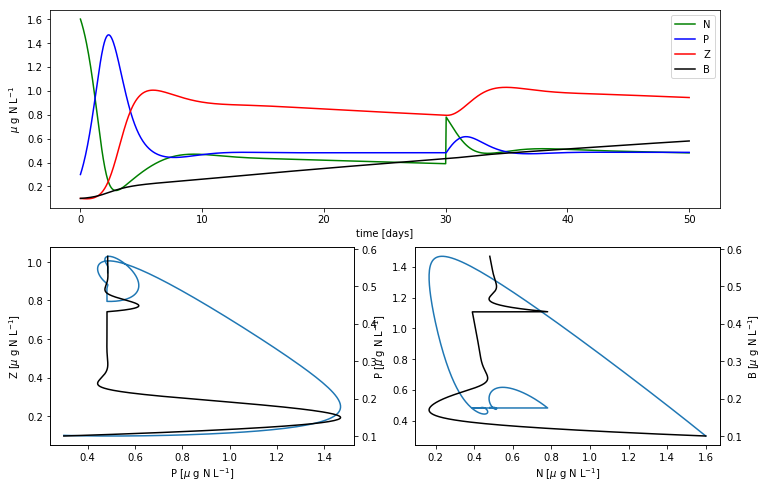

In [13]:
times,N,P,Z,B=npz()

fig = plt.figure(figsize=(12,8))
ax = [0, 0, 0]
ax[0] = plt.subplot2grid((2,2), (0,0), colspan=2)
ax[1] = plt.subplot2grid((2,2), (1,0))
ax[2] = plt.subplot2grid((2,2), (1,1))

ax[0].plot(times,N,'g',times,P,'b',times,Z,'r',times,B,'k')
ax[0].set_xlabel("time [days]")
ax[0].set_ylabel("$\mu$ g N L$^{-1}$")
ax[0].legend(["N","P","Z","B"])

bx = ax[1].twinx()
ax[1].plot(P,Z)
bx.plot(P,B,'k')
ax[1].set_xlabel("P [$\mu$ g N L$^{-1}$]")
ax[1].set_ylabel("Z [$\mu$ g N L$^{-1}$]")

bx = ax[2].twinx()
ax[2].plot(N,P)
bx.plot(N,B,'k')
ax[2].set_xlabel("N [$\mu$ g N L$^{-1}$]")
ax[2].set_ylabel("P [$\mu$ g N L$^{-1}$]")
bx.set_ylabel("B [$\mu$ g N L$^{-1}$]")

Case Studies
-------------

Now, conduct a number of case studies by calling the model, but changing various parameters to examine the impact they have upon the system. For instance, the rates at which nutrients are exchanged with the benthos may have a profound effect on the bloom and the subsequent fixed-points. What about the impact of "messy-eating", initialization, or uptake rates?